# BBC News Classification: Matrix Factorization Assignment

This is a submission for the Kaggle competition: https://www.kaggle.com/competitions/learn-ai-bbc/overview

**Competition Overview**

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.
The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

In [55]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.metrics import *
from sklearn.decomposition import NMF

## Exploratory Data Analysis

As described above, the data was provided by Kaggle for this competition. In this section we will be uploading, exploring, and cleaning our datasets.

### Initial Data Loading and Preprocessing

In [2]:
# upload training, testing, and solution data
train_data = pd.read_csv('BBC News Train.csv')
test_data = pd.read_csv('BBC News Test.csv')
solutions = pd.read_csv("BBC News Sample Solution.csv")

In [3]:
# check each dataset for nulls
print("Training Data")
print(train_data.isna().sum())
print(f"\nTesting Data")
print(test_data.isna().sum())
print(f"\nSolutions")
print(solutions.isna().sum())

Training Data
ArticleId    0
Text         0
Category     0
dtype: int64

Testing Data
ArticleId    0
Text         0
dtype: int64

Solutions
ArticleId    0
Category     0
dtype: int64


No nulls exist in the datasets, so no adjustments needed there.

In [4]:
# check each data set for data types
print("Training Data")
print(train_data.dtypes)
print(f"\nTesting Data")
print(test_data.dtypes)
print(f"\nSolutions")
print(solutions.dtypes)

Training Data
ArticleId     int64
Text         object
Category     object
dtype: object

Testing Data
ArticleId     int64
Text         object
dtype: object

Solutions
ArticleId     int64
Category     object
dtype: object


We just need to make the Text data into a list of strings (words) for easier handling.


In [5]:
# make Text columns lists of strings (words)
train_data['Text'] = train_data['Text'].apply(lambda x: x.split())
test_data['Text'] = test_data['Text'].apply(lambda x: x.split())

In [6]:
# now inspect dataframes to make sure all changes were made correctly and no other changes needed
print(train_data.head())
print(test_data.head())
print(solutions.head())

   ArticleId                                               Text  Category
0       1833  [worldcom, ex-boss, launches, defence, lawyers...  business
1        154  [german, business, confidence, slides, german,...  business
2       1101  [bbc, poll, indicates, economic, gloom, citize...  business
3       1976  [lifestyle, governs, mobile, choice, faster, b...      tech
4        917  [enron, bosses, in, $168m, payout, eighteen, f...  business
   ArticleId                                               Text
0       1018  [qpr, keeper, day, heads, for, preston, queens...
1       1319  [software, watching, while, you, work, softwar...
2       1138  [d, arcy, injury, adds, to, ireland, woe, gord...
3        459  [india, s, reliance, family, feud, heats, up, ...
4       1020  [boro, suffer, morrison, injury, blow, middles...
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138       business
3        459  entertainment
4       1020       politics


All our data is in the proper formats and we don't have any missing pieces.

### Clean Terms of Grammar Issues

The next step in the data cleaning process is to get our text data into a usable format. This means getting all our terms in our training test set, cleaning them so they are as usable as possible, and keeping them as a reference for cleaning our datasets and building our matrices.

In [7]:
# get unique set of terms found in training data
terms = set()
for term_set in train_data['Text']:
    terms.update(term_set)
# make into an ordered list for easy use
terms = sorted(list(terms))

print(len(terms))
print(terms)

35594
['!', '$$$.', '$0.99', '$1', '$1.13bn', '$1.15', '$1.1bn', '$1.20', '$1.25', '$1.2871', '$1.2944', '$1.2974', '$1.2bn', '$1.3', '$1.30', '$1.30.', '$1.3006', '$1.32', '$1.3218', '$1.3280', '$1.35', '$1.3509.', '$1.3516', '$1.354', '$1.364', '$1.3652', '$1.3667', '$1.3bn', '$1.40', '$1.4850', '$1.50', '$1.5bn', '$1.5m', '$1.64', '$1.6bn', '$1.75bn', '$1.76', '$1.7bn', '$1.7m', '$1.8', '$1.83', '$1.87bn', '$1.89', '$1.8bn', '$1.8bn.', '$1.8m', '$1.90', '$1.9094.', '$1.9bn', '$10', '$10-25m', '$10.44', '$10.48', '$10.7bn', '$10.7m', '$10.85m', '$10.9bn.', '$100', '$100bn', '$100m', '$100m-share', '$102.6bn', '$105bn', '$10bn', '$10m', '$11.1bn', '$11.2m', '$11.5bn', '$11.8m', '$110', '$110m', '$111m', '$113bn.', '$119bn', '$11bn', '$11m', '$12', '$12.05bn.', '$12.2m', '$12.5m', '$12.7m', '$12.8bn', '$12.8m', '$120bn', '$120m', '$121.9m', '$124bn', '$125', '$125.4m', '$125.73', '$125m', '$12bn.', '$13.5', '$133m', '$137m', '$138m', '$13m', '$14', '$14.1bn', '$14.2bn', '$14.35', '$14.

It looks like we need to clean up our terms data. We want terms to be as reusable as possible so as to keep efficiency high and memory low. Here are some changes that I will introduce both to our full terms set and to the text data for each article in the training and testing data sets.

#### Grammar Rules

1. Isolate '!', '%', '$', and '£' as their own terms.

2. Remove '(', ')', '[', ']', ';', '&', '#', '...' and ':' from all terms.

3. Identify digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) and mark as a digit character. Do this by replacing any substring including these with '9' (substitute for all digit combinations possible). For example, 10.2bn will become 99.9bn, 1025 will become 9999 and 24-25 will become 99-99.

4. Remove '.', '`', and '-' only when it is the last or first character in the term.

5. Split terms with '-' into two.

Note: I am keeping '/' in place because they hold meaningful changes for the terms they occur in only when they are in place. For example, '/' is needed to express fractions.

In [8]:
# initialize lists of characters for searching through to apply rules
rule1 = ['!', '%', '$', '£']
rule2 = ['(', ')', '[', ']', ';', '&', '#', '...', ':']
rule3 = ['0', '1', '2', '3', '4', '5', '6', '7', '8'] # don't include 9 because will be default digit

In [9]:
# create function to apply grammar rules

def assert_grammar_rules(term_iter): # input is a list of terms (strings)
    # initialize new set
    new_terms = {'!', '%', '$', '£'} # initialize new terms set with rule 1 characters to avoid extra code later

    for term in term_iter:
        # Isolate terms from rule1 and add to terms list
        for char1 in rule1:
            if char1 in term:
                # char1 is already stored; remove it from the term
                term = term.replace(char1, '')
                # now you can continue with the term as it is since all rule 1 characters are already in the grammar_terms set
        if len(term) > 0: # in case the term was only char1
            # Remove terms from rule 2
            for char2 in rule2:
                if char2 in term:
                    term = term.replace(char2, '')
            if len(term) > 0: # in case the term was only char2
                # Replace digits with 9 (Rule 3)
                for digit in rule3:
                    if digit in term:
                        term = term.replace(digit, '9')
                # Remove . if last or first character in term (Rule 4)
                # grab last character
                last = term[-1]
                if last == '.' or last == '-' or last == '`':
                    term = term[:-1]
                if len(term) > 0: # in case the term was only .
                    first = term[0]
                    if first == '.' or first == '-' or first == '`':
                        term = term[1:]
                    if len(term) > 0: # in case the term was only .
                        parts = term.split('-') # split string up to 2 times (for a max of 3 seperate terms)
                        # add term to grammar_terms set
                        new_terms.add(parts[0])
                        if len(parts) > 1:
                            new_terms.add(parts[1])
                            if len(parts) > 2:
                                new_terms.add(parts[2])

    # make our set into an iterable again
    return sorted(list(new_terms))

In [10]:
# apply the new function
terms = assert_grammar_rules(terms)

print(len(terms))
print(terms)

23819
['!', '$', '%', '*', '/', '/gt', '9', '9+9=9', '9.9', '9.99', '9.999', '9.9999', '9.99bn', '9.99gbps', '9.99m', '9.99p', '9.99pm', '9.99secs', '9.9bn', '9.9cm', '9.9ft', '9.9g', '9.9g/wi', '9.9gb', '9.9ghz', '9.9km', '9.9m', '9.9m/h', '9.9p', '9/9', '9/99', '9/9rds', '99', '99.9', '99.99', '99.999', '99.99bn', '99.99m', '99.99seconds', '99.99secs', '99.9bn', '99.9km', '99.9m', '99.m', '99/9', '99/99', '999', '999.9', '999.99', '999.999', '999.99bn', '999.99m', '999.99p', '999.9bn', '999.9m', '999.9p', '9999', '9999.99', '9999.9m', '9999/9', '9999/99', '9999/9999', '99999', '999999', '99999999999', '9999alleging', '9999fetched', '9999gmt', '9999m', '9999p', '9999s', '9999th', '999and', '999bn', '999gb', '999i', '999kbps', '999kg', '999km', '999lr', '999m', '999m99.9m', '999mb', '999ml', '999p', '999st', '999th', '99a', '99bn', '99c', '99cm', '99ft', '99gb', '99k', '99km/h', '99lb', '99m', '99m/s', '99mbps', '99mg', '99mm', '99mph', '99nd', '99p', '99pc', '99pm', '99rd', '99s', '99

We reduced our term count from over 35,000 to under 24,000 just by fixing grammar issues.

### Lemmatization and Stemming

Now that our term list is clean of grammatical issues, we want to get every word as close to its dictionary form in a process called lemmatization and stemming. The goal is to further reduce the total count of terms such that terms that are the same in meaning are not double counted. For instance, we want "run", "runs", "running" and "ran" to all be counted as the same word, "run". Here are some rules we'll implement to get as many corrections as possible in without too much complication.

#### L&S Rules

1. Implement a dictionary of irregular terms mapped to their generic version.

2. Change all numbers (9's) to simply be includes_number category.

    a. If letters follow, separate into another term and use units dictionary to identify stem.

3. Fix contraction issues. (Split at apostrophe earlier.)

    a. If ends in -consonant-n, but not -rn, remove -n.

    b. 't' and 've' mapped to 'not' and 'have' in irregular dictionary. 

3. Change plurals to singular.

    a. If ends in -ies, replace with -y.

    b. If ends in -es and letters before that are -s, -x, -z, -sh, -ch, remove -es.

    c. If word ends in -s and none of above are true annd not -ss, remove -s.

4. Get rid of past tense.

    a. If ends in -ied, replace with -y.

    b. If ends in -ed and prior letter combo is consonant-consonant, remove -ed.

    c. If ends in -ed and prior letter combo is vowel-consonant, remove -d.

5. Get rid of gerunds.

    a. If -ying, replace with -ie.

    b. If -ing and prior letter is a consonant, remove.

6. Remove superlatives.

    a. If ends in -er or -est, remove.

7. Remove general endings, including -ly, -ment, -ness, -less, -able, -ible, -ful.

**NOTE: I used ChatGPT to help me come up with this list of rules and with the following dictionary of irregular words to map.**

In [11]:
# create irregular and unit dictionaries

irregular_map = {
    # verbs
    "am": "be",
    "is": "be",
    "are": "be",
    "was": "be",
    "were": "be",
    "being": "be",
    "been": "be",

    "has": "have",
    "had": "have",
    "having": "have",

    "does": "do",
    "did": "do",
    "doing": "do",

    "goes": "go",
    "went": "go",
    "gone": "go",
    "going": "go",

    "says": "say",
    "said": "say",

    "saw": "see",
    "seen": "see",

    "came": "come",
    "became": "become",

    "made": "make",

    "got": "get",
    "gotten": "get",

    "takes": "take",
    "took": "take",
    "taken": "take",

    "ran": "run",

    "found": "find",

    "told": "tell",

    "brought": "bring",
    "bought": "buy",
    "thought": "think",
    "taught": "teach",
    "caught": "catch",
    "fought": "fight",
    "sought": "seek",

    "knew": "know",
    "known": "know",

    "could": "can",
    "would": "will",

    # nouns
    "men": "man",
    "women": "woman",
    "children": "child",
    "people": "person",
    "mice": "mouse",
    "teeth": "tooth",
    "feet": "foot",
    'bytes': "bits",

    # adjectives/adverbs
    "better": "good",
    "best": "good",
    "worse": "bad",
    "worst": "bad",
    "further": "far",

    # contractions fix
    've': 'have',
    't': 'not'
}

unit_map = {
    'bn': "billion",
    'p': 'pence',

    'gbps': 'bit', # gigabits per second
    'kbps': 'bit', # kilobits per second
    'mbps': 'bit', # megabits per second
    'gb': 'bit', # gigabytes
    'mb': 'bit', # megabytes

    'm': 'meter',
    'm/s': 'meter', # per second
    'mm': 'meter', # millimeter
    'cm': 'meter', # centimeter
    'km': 'meter', # kilometer
    'km/h': 'meter', # kilometer per hour
    'm/h': 'meter', # per hour

    'am': 'morning', # after a time
    'pm': 'evening', # after a time
    'secs': 'seconds',
    's': 'seconds',
    'gmt': 'time', # greenwich mean time

    'ft': 'feet',
    'mph': 'mile', # per hour
    'lb': 'pound',
    'in': 'inch',

    'g': 'gram',
    'mg': 'gram', # milligram
    'kg': 'gram', # kilogram
    
    'ghz': 'hertz', # gigahertz
    
    'rds': '', # thirds
    'rd': '', # third
    'th': '', # ordinal
    'st': '', # first
    'nd': '', # second

    
    'ml': 'liter', # milliliters
    'l': 'liter',

    'c': 'celsius', 
     
    'kw': 'watt' # kilowatt
} 
# if not in unit_map, just count as itself

In [12]:
# create function to check if consonant
def is_consonant(char):
    if type(char) is not str:
        return False
    if char in ['a', 'e', 'i', 'o', 'u', 'y']:
        return False
    else:
        return True

In [13]:
# create function for finding last four letters of a string for easy resuability in next function
def find_final_chars(word):
    # set defaults
    last_char = ''
    penult_char = ''
    antepenult_char = ''
    preantepenult_char = ''
    
    if len(word) > 0:
        last_char = word[-1]
        if len(word) > 1:
            penult_char = word[-2]
            if len(word) > 2:
                antepenult_char = word[-3]
                if len(word) > 3:
                    preantepenult_char = word[-4]        
    
    return preantepenult_char, antepenult_char, penult_char, last_char

In [14]:
# create new function to apply l&s rules

def assert_ls_rules(term_iter): # input is a list of strings
    # set up new terms set
    new_terms = {'includes_number'}

    # loop through terms to apply rules
    for term in term_iter:

        # map to irregular dict if applicable (Rule 1)
        if term in irregular_map:
            new_terms.add(irregular_map[term])
            continue # continue to next word

        # grab last characters for later comparisons
        preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)

        # deal with numbers and their units (Rule 2)

        if '9' in term:
            if last_char != '9': # when a unit is included (last character != 9)
                num, unit = term.rsplit('9', 1) # max of 1 split (2 parts)
                # deal with unit; number already in set
                if unit in unit_map: # remap unit abbreviations
                    mapped_word = unit_map[unit]
                    if len(mapped_word) > 0: # some mappings are empty strings
                        new_terms.add(unit_map[unit])
                else: # unit not specified
                    new_terms.add(unit)
            continue

        ##### VERBS #########

        # fix contraction issues (Rule 3)
        if last_char == 'n' and len(term) > 1: # ignore if the term == 'n'
            if is_consonant(penult_char) and penult_char != 'r': # ending is not -rn or -vowel-n
                term = term[:-1] # remove the last character, -n
                # reset last characters for later comparisons
                preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)

        # fix gerunds (Rule 6)
        if antepenult_char + penult_char + last_char == 'ing':
            if preantepenult_char == 'y':
                term = term[:-4] + 'ie' # replace -ying with -ie
            else:
                term = term[:-3] # remove -ing
                # clean up word; if double letter ending (pp, ll, etc.) remove last letter
                if len(term) > 1:
                    check_letter = term[-2]
                    if check_letter == preantepenult_char:
                        term = term[:-1]
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        
        # fix past tenses (Rule 5)
        if penult_char + last_char == 'ed': # ending is -ed
            if is_consonant(antepenult_char): # ending is conso-ed
                if is_consonant(preantepenult_char) and  preantepenult_char + antepenult_char != 'dg': # ending is conso-conso-ed
                    term = term[:-2] # remove -ed
                else: # root ending is vow-conso-ed
                    term = term[:-1] # remove -d
            elif preantepenult_char == 'i': # ending is -ied
                term = term[:-3] + 'y' # change from -ied to -y
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)

        ##### NOUNS ###########

        # fix plurals (Rule 4)
        if last_char == 's':
            if penult_char == 'e':
                if antepenult_char == 'i':
                    term = term[:-3] + 'y' # replace -ies with -y
                    # reset last characters for later comparisons
                    preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
                if antepenult_char in ['s', 'x', 'z']:
                    term = term[:-2] # remove -es
                    # reset last characters for later comparisons
                    preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
                if antepenult_char == 'h':
                    if preantepenult_char in ['c', 's']: # if ending is -ches or -shes
                        term = term[:-2] # remove -es
                        # reset last characters for later comparisons
                        preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
            if penult_char != 's' and antepenult_char + penult_char + last_char != 'ous' and penult_char + last_char != 'is': # if ending is not -ss or -ous (like in mass or famous or analysis)
                term = term[:-1] # remove pluralizing -s
                # reset last characters for later comparisons
                preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
            

        
        # remove common suffixes (Rule 8)
        if penult_char + last_char == 'ly':
            term = term[:-2] # remove -ly
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if antepenult_char + penult_char + last_char == 'ful':
            term = term[:-3] # remove -ful
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if preantepenult_char + antepenult_char + penult_char + last_char == 'ment':
            term = term[:-4] # remove -ment
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if preantepenult_char + antepenult_char + penult_char + last_char == 'ness':
            term = term[:-4] # remove -ness
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if preantepenult_char + antepenult_char + penult_char + last_char == 'less':
            term = term[:-4] # remove -less
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if preantepenult_char + antepenult_char + penult_char + last_char == 'able':
            term = term[:-4] # remove -able
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if preantepenult_char + antepenult_char + penult_char + last_char == 'ible':
            term = term[:-4] # remove -ible
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)

        # fix superlatives (Rule 7)
        if antepenult_char + penult_char + last_char == 'est':
            term = term[:-3] # remove -est
            # reset last characters for later comparisons
            preantepenult_char, antepenult_char, penult_char, last_char = find_final_chars(term)
        if penult_char + last_char == 'er':
            term = term[:-2] # remove -er

        # all necessary changes have been made; add to new_terms
        if len(term) > 0:
            new_terms.add(term)

    return sorted(list(new_terms))

In [15]:
# apply our new function to terms
terms = assert_ls_rules(terms)

print(len(terms))
print(terms)

17884
['!', '$', '%', '*', '.m', '/', '/gt', 'a', 'a.d', 'aa', 'aaa', 'aac', 'aadc', 'aaliyah', 'aaltra', 'aamir', 'aaron', 'ab', 'abacu', 'abandon', 'abandone', 'abat', 'abba', 'abbasi', 'abbott', 'abbreviate', 'abc', 'abd', 'abdellatif', 'abdication', 'abdomen', 'abdominal', 'abduct', 'abduction', 'abdullah', 'abdullatif', 'abebe', 'aberdeen', 'aberration', 'aberystwyth', 'abeyance', 'abeyie', 'abhorrent', 'abi', 'abid', 'abide', 'abigail', 'abilit', 'ability', 'abish', 'abnormal', 'abnormality', 'abolish', 'abolition', 'abort', 'abortion', 'abortionist', 'abortive', 'about', 'above', 'abramovich', 'abroad', 'abrupt', 'absa', 'absence', 'absent', 'absentee', 'absolute', 'absolution', 'absorb', 'abstain', 'abstention', 'absurd', 'abtahi', 'abu', 'abundance', 'abundant', 'aburizal', 'abuse', 'abusive', 'abut', 'abuzz', 'abysmal', 'ac', 'ac/dc', 'academ', 'academic', 'academie', 'academy', 'acapulco', 'acc', 'acce', 'accelerat', 'accelerate', 'acceleration', 'accelerator', 'accent', 'ac

Our vocabulary length was reduced from over 23,000 to under 18,000 through lemmatization and stemming.

Before we get into that, we'll need to create and apply a function that will clean our text data in our training and testing sets with the same rules that we used for cleaning our overall terms list.

In [16]:
def clean_terms(article_terms):
    intermediate_list = assert_grammar_rules(article_terms)
    final_list = assert_ls_rules(intermediate_list)
    return final_list

In [17]:
# now we will apply our new cleaning function to our training and testing data
train_data['Text'] = train_data['Text'].apply(clean_terms)
test_data['Text'] = test_data['Text'].apply(clean_terms)

### Remove Infrequent and Insignificant Words

Words that only show up a couple times are not useful for classification problems. To reduce our terms list further, we will remove terms that only show up in less than 1% of the articles in the training set.

In [18]:
# get count of number of articles each term appears in and frequency per category

# initialize topic mapping
topics = list(train_data['Category'].unique())
topic_nums = [0, 1, 2, 3, 4]
topic_mapping = dict(zip(topics, topic_nums))

# initialize dictionaries
term_doc_freq = dict.fromkeys(terms, 0)

term_topic_freq = {term: [0, 0, 0, 0, 0] for term in terms} # values will be a list of counts per topic with index based on topic mapping dictionary

topic_word_count = dict.fromkeys(topics, 0) # tracking overall word counts of each topic for getting proportions later and evaluating size differences


for ii in range(train_data.shape[0]):
    # get text and topic data for the row/document
    article = train_data.loc[ii, 'Text']
    topic = train_data.loc[ii, 'Category']
    # update topic_word_count dictionary
    # get total word count of article
    doc_word_count = len(article)
    topic_word_count[topic] += doc_word_count
    
    for term in term_doc_freq:
        if term in article:

            # update term_doc_freq dictionary
            # increase count of document appearances for the term 
            term_doc_freq[term] += 1
            
            # update term_topic_freq dictionary
            # get the topic index for mapping
            topic_id = topic_mapping[topic]

            # count the number of times it appears in the document
            count_in_doc = article.count(term)

            # add count to the proper topic index of the list for that term in term_topic_freq
            term_topic_freq[term][topic_id] += count_in_doc

# make term_doc_freq values from counts to frequencies (divide each by total number of documents in set)
num_docs = train_data.shape[0]
term_doc_freq = {term: count / num_docs for term, count in term_doc_freq.items()}

# make term_topic_freq values from counts to frequencies (divide by appropriate topic word counts)
# create topic total word count list in correct order
topic_word_count_list = [0, 0, 0, 0, 0]
for topic, count in topic_word_count.items():
    # get correct index
    correct_id = topic_mapping[topic]
    # update count list
    topic_word_count_list[correct_id] = count

for term, topic_list in term_topic_freq.items():
    # divide topic_list by list of topic total word counts
    term_topic_freq[term] = [count / total for count, total in zip(topic_list, topic_word_count_list)]

print(f"\nTopic Total Word Counts: {topic_word_count}")


Topic Total Word Counts: {'business': 56506, 'tech': 58141, 'politics': 56840, 'sport': 59089, 'entertainment': 46710}


Now that we have frequencies for each term based on documents and topics, let's inspect some plot of the frequencies to get a better understanding of the shape of our data for these terms. 

First, we'll look at the ranges of frequencies for each term with respect to topics. Then, we'll inspect the frequencies if terms by document.

To look at the ranges with respect to topics, we'll need to calculate the range of each term and then plot them.

In [20]:
# get and store range data
term_topic_freq_range = dict.fromkeys(terms)

for term, topic_list in term_topic_freq.items():
    # get range of list values
    smallest_freq = min(topic_list)
    largest_freq = max(topic_list)
    range_value = largest_freq - smallest_freq
    # assign to range dictionary
    term_topic_freq_range[term] = range_value

range_data = list(term_topic_freq_range.values())

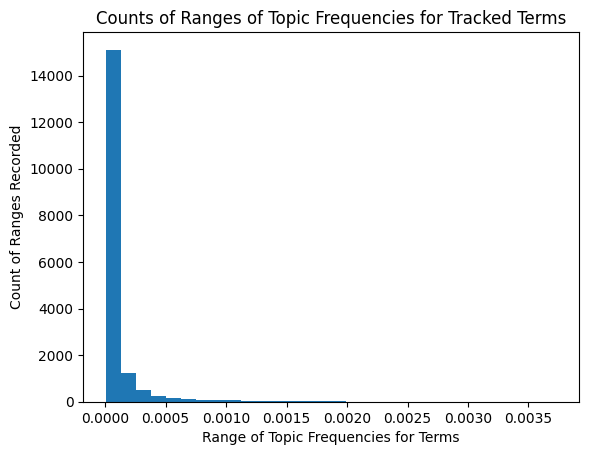

In [21]:
# plot range data
# create plot
plt.figure()
plt.hist(range_data, bins = 30)
plt.xlabel("Range of Topic Frequencies for Terms")
plt.ylabel("Count of Ranges Recorded")
plt.title("Counts of Ranges of Topic Frequencies for Tracked Terms")
plt.show()

We want our range between topics for a term to be large, otherwise the term is not contributing much to the classification process. Let's get a set of the terms that excludes the terms with ranges less than 0.0005.

In [22]:
# create set of terms with significant ranges
significant_terms = set(term for term, range_value in term_topic_freq_range.items() if range_value > 0.001)

print(len(significant_terms))
print(significant_terms)

275
{'sing', 'financial', 'bank', 'victory', 'actor', 'help', 'ov', 'find', 'final', 'on', 'tory', 'form', 'lead', 'minute', 'public', 'when', 'sugg', 'consum', 'council', 'there', 'executive', 'device', 'includ', 'one', 'comedy', 'him', 'develop', 'music', 'share', 'most', 'data', 'report', 'busi', 'between', 'week', 'so', 'economic', 'about', 'any', 'minist', 'cut', 'govern', 'those', 'championship', 'tor', 'album', 'bbc', 'growth', 'trade', 'use', 'defend', 'increase', 'web', 'common', 'but', 'election', 'my', 'two', 'm', 'success', 'way', 'played', 'system', 'launch', 'second', 'digital', 'france', 'hit', 'hollywood', 'the', '!', 'chancellor', 'campaig', 'and', 'more', 'technology', 'vote', 'such', 'title', 'these', 'team', 'song', 'just', 'film', 'he', 'firm', 'don', 'year', 'work', 'need', 'online', 'vot', 'price', 'rise', 'show', 'saie', 'side', 'who', 'be', 'own', 'recent', 'general', 'mp', 'research', 'go', 'director', 'game', 'last', 'chart', 'cost', 'uk', 'in', 'person', 'wa

[0.053691275167785234, 0.09194630872483221, 0.08590604026845637, 0.06040268456375839, 0.05704697986577181, 0.21677852348993287, 0.42953020134228187, 0.2080536912751678, 0.138255033557047, 0.9221476510067114, 0.056375838926174496, 0.24228187919463087, 0.24496644295302014, 0.08322147651006712, 0.14496644295302014, 0.38053691275167784, 0.10671140939597315, 0.07852348993288591, 0.06040268456375839, 0.4181208053691275, 0.11275167785234899, 0.04899328859060403, 0.1483221476510067, 0.48389261744966444, 0.038926174496644296, 0.17785234899328858, 0.10939597315436242, 0.10939597315436242, 0.13221476510067115, 0.2516778523489933, 0.06442953020134229, 0.20939597315436242, 0.13758389261744966, 0.18859060402684563, 0.2697986577181208, 0.31610738255033555, 0.087248322147651, 0.43221476510067114, 0.23825503355704697, 0.15771812080536912, 0.1174496644295302, 0.22617449664429531, 0.18456375838926176, 0.04832214765100671, 0.056375838926174496, 0.03422818791946309, 0.19932885906040268, 0.10134228187919463

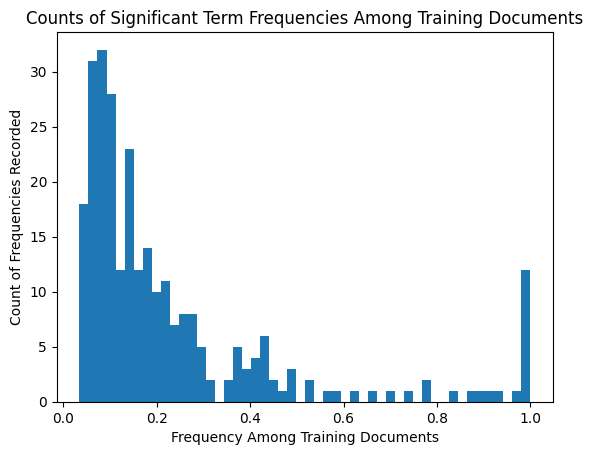

In [23]:
# retrieve shortened dictionary of term_doc_freq that only includes significant words
significant_term_doc_freq = dict.fromkeys(significant_terms)

for term in significant_term_doc_freq:
    freq = term_doc_freq[term]
    significant_term_doc_freq[term] = freq

freq_data = list(significant_term_doc_freq.values())

print(freq_data)

# plot frequencies of significant terms across all documents
plt.figure()
plt.hist(freq_data, bins = 50)
plt.xlabel("Frequency Among Training Documents")
plt.ylabel("Count of Frequencies Recorded")
plt.title("Counts of Significant Term Frequencies Among Training Documents")
plt.show()

In [24]:
# calculate topic proportions of training documents
for topic in topics:
    # count number of documents that are assigned to that topic
    doc_count = (train_data['Category'] == topic).sum()
    print(doc_count / num_docs)

0.22550335570469798
0.17516778523489934
0.18389261744966443
0.23221476510067113
0.18322147651006712


The topics each make up 17-24% of the total number of documents. Therefore, we do not want to keep any terms that show up in more than 24% of the documents, as they will be appearing across categories. We also do not want to keep words that only show up in a tiny portion of the documents since they will not be useful for labeling either and are only likely to make our model overfit.

In [25]:
# grab terms with more than mininimum threshold frequency
significant_terms = [word for word, freq in significant_term_doc_freq.items() if freq > 0.05 and freq < 0.24] # removing words that only occur in 1% of documents

print(len(significant_terms))
print(significant_terms)

181
['sing', 'financial', 'bank', 'victory', 'actor', 'help', 'find', 'final', 'tory', 'minute', 'public', 'sugg', 'consum', 'council', 'executive', 'includ', 'him', 'develop', 'music', 'share', 'data', 'report', 'busi', 'between', 'economic', 'any', 'minist', 'cut', 'govern', 'those', 'tor', 'bbc', 'growth', 'trade', 'defend', 'increase', 'web', 'common', 'election', 'my', 'm', 'success', 'played', 'system', 'launch', 'second', 'digital', 'france', 'hit', 'chancellor', 'campaig', 'technology', 'vote', 'title', 'these', 'team', 'film', 'firm', 'don', 'need', 'online', 'vot', 'price', 'rise', 'show', 'saie', 'side', 'own', 'recent', 'general', 'mp', 'research', 'director', 'game', 'cost', 'buy', 'many', 'should', 'howard', 'profit', 'match', 'start', 'democrat', 'mobile', 'service', 'plaie', 'release', 'comput', 'rate', 'season', 'nation', 'top', 'great', 'six', 'us', 'accord', 'group', 'tony', 'win', 'britain', 'company', 'prime', 'labour', 'chief', 'goal', 'bigg', 'include', 'old', 's

Wow! We got our potential terms from over 17,000 to under 200.

### Remove Stopwords

Let's begin removing stopwords. Stopwords are basic words that are repeated many times no matter what the subject is. Think of words like "a", "the", "and", etc. To complete this part of the cleaning, we'll use an imported stopword list.

In [26]:
# get stop words list
stop_words = set(stopwords.words('english'))

# filter out stop words from significant terms list
final_terms_list = [word for word in significant_terms if word not in stop_words]

print(len(final_terms_list))
print(final_terms_list)

165
['sing', 'financial', 'bank', 'victory', 'actor', 'help', 'find', 'final', 'tory', 'minute', 'public', 'sugg', 'consum', 'council', 'executive', 'includ', 'develop', 'music', 'share', 'data', 'report', 'busi', 'economic', 'minist', 'cut', 'govern', 'tor', 'bbc', 'growth', 'trade', 'defend', 'increase', 'web', 'common', 'election', 'success', 'played', 'system', 'launch', 'second', 'digital', 'france', 'hit', 'chancellor', 'campaig', 'technology', 'vote', 'title', 'team', 'film', 'firm', 'need', 'online', 'vot', 'price', 'rise', 'show', 'saie', 'side', 'recent', 'general', 'mp', 'research', 'director', 'game', 'cost', 'buy', 'many', 'howard', 'profit', 'match', 'start', 'democrat', 'mobile', 'service', 'plaie', 'release', 'comput', 'rate', 'season', 'nation', 'top', 'great', 'six', 'us', 'accord', 'group', 'tony', 'win', 'britain', 'company', 'prime', 'labour', 'chief', 'goal', 'bigg', 'include', 'old', 'software', 'issue', 'secretary', 'inv', 'pc', 'chance', 'may', 'information', '

We have gotten our terms list from 181 to 165.

Further tweaks could be made to our L&S rules function, but the time it would take does not provide as much benefit. Therefore, we will go ahead with this term list.

In [27]:
# rename to terms for easy use later
terms = final_terms_list

## Word Embedding: TF-IDF

To complete our topic modeling assignment, we need to have a word embedding process to calculate the importance of each term to each topic. I have chosen to use TF-IDF (Term Frequency-Inverse Document Frequency) because it is interpretable. This word embedding simply takes the proportion of a document that word makes up in its word count and multiplies it by the proportion of words it takes up amoung the word count of the entire training data set.

In [28]:
# find inverse document frequency (IDF) -> frequency of word among all documents

# make a dictionary out of terms and count the number of times it appears in all documents
idf = dict.fromkeys(terms, 0)

# total number of documents stored in num_docs
# number of docs containing the term is stored in dictionary term_doc_freq

# loop through idf keys
for word in idf:
    # get number of documents it is stored in
    doc_count = term_doc_freq[word]
    # calculate idf
    idf_value = np.log(num_docs / doc_count) + 1
    # assign to idf dict
    idf[word] = idf_value

In [29]:
# create function to build tf-idf matrix
# will be used for both training and testing data

def build_tfidf_matrix(df):

    # create empty np matrix with docs x terms
    num_articles = df.shape[0]
    num_terms = len(terms)
    mat = np.zeros((num_articles, num_terms))

    # count number of times each word appears in each document and divide by the document's word count

    for n in range(num_articles): # loop through rows (docs)
        # get text from each article
        text = df['Text'].iloc[n]
        # get word count for calculating frequencies
        word_count = len(text)
        for m in range(num_terms): # loop through cols (terms)
            # get word to count
            word = terms[m]
            # get idf value
            idf_value = idf[word]
            # count the number of times the word appears in this article
            instances = text.count(word)
            # calculate the frequency of this word in this document
            tf = instances / word_count
            # calculate tf-idf
            freq = tf * idf_value
            # assign to appropriate matrix position
            mat[n, m] = freq

    # normalize the matrix
    norm_mat = normalize(mat, norm = 'l2', axis = 1) # use L2 (vector) normalization on rows (per document)

    return norm_mat

In [30]:
# build training tf-idf matrix
dt_matrix = build_tfidf_matrix(train_data)

## Build Label and Solutions Matrices

Finally, we will need a matrix of documents and topics to encode our labels for our training data. In this part, we'll do the same with our solutions data for evaluating our models later.

In [31]:
# initialize label matrix
num_topics = len(topics)
label_matrix = np.zeros((num_docs, num_topics))

# initialize solutions matrix
test_size = test_data.shape[0]
solutions_matrix = np.zeros((test_size, num_topics))

# loop through each topic and mask the df to get boolean values
for ii in range(num_topics):
    # get topic
    topic = topics[ii]

    # mask label data and add to label_matrix
    topic_df = train_data['Category'] == topic
    label_matrix[:, ii] = topic_df.astype(int)

    # mask solutions data and add to solutions_matrix
    sol_df = solutions['Category'] == topic
    solutions_matrix[:, ii] = sol_df.astype(int)

## Optimizer

Now that our data has been properly placed into a TF-IDF matrix and normalized (to exclude overweighing documents that are significantly longer than others), we need to optimize the weights of each term for each topic. I am conducting logistic regression to find the parameters and then using gradient descent to optimize them. First, let's define functions for our softmax function (since we have multiple potential labels), our loss function (cross entropy), and to conduct our gradient descent parameter update.

In [32]:
# create function to calculate soft max (sigmoid function) and return predictions

def make_predictions(X, W, b):
    # input: X is a TF-IDF matrix (docs x terms) -> TF-IDF matrix
    #        W is a matrix of the weights (terms x categories) -> weight matrix
    #        b is a vector of biases to add (1 x categories)
    # output: S is a matrix of probabilities each sample belongs in each category (docs x categories)

    # get z-scores -> Z is a matrix of z-scores (docs x categories)
    Z = X @ W + b # automatically broadcasts b to every row 

    # get elements needed for formula
    e_z = np.exp(Z) # e^z for each entry in Z

    S = e_z / np.sum(e_z, axis = 1).reshape(-1, 1)

    return S


In [33]:
# create a function to calculate loss (cross entropy formula)

def calculate_loss(L, S):
    # input: L is a matrix of each document's true label (docs x categories) -> label_matrix
    #        S is a matrix of the label probabilities for each document (docs x categories) -> label_matrix but for predictions (output of softmax)
    # output: cross_entropy is a scalar refelecting the total entropy across all categories

    # get formula elements
    num_docs = L.shape[0]
    log_S = np.log(S + 1e-10) # get log of S; 1e-10 protects against log(0)
    neg_averager = -1 / num_docs

    cross_entropy = neg_averager * np.sum(L * log_S)

    return cross_entropy # 0 = perfect predictions (want to minimize this number)

In [34]:
# create function for updating our parameters through gradient descent optimization

def update_parameters(X, L, S, W, b, alpha):
    # inputs: X is a TF-IDF matrix (docs x terms) -> TF-IDF matrix
    #         L is a matrix of each document's true label (docs x categories) -> label_matrix
    #         S is a matrix of the label probabilities for each document (docs x categories) -> label_matrix but for predictions (output of softmax)
    #         W is a matrix of the weights (terms x categories) -> weight matrix
    #         b is a vector of biases to add (1 x categories) 
    #         alpha is a constant that reflects the learning rate
    # outputs: updated W and b

    # get elements for calculating derivatives
    ls_part = L - L*S # (docs x categories)
    num_docs = L.shape[0]
    neg_averager= -1 / num_docs

    # find derivative of cross entropy with respect to biases, b
    db = np.sum(ls_part, axis = 0) * neg_averager # (1 x categories)

    # find derivative of cross entropy with respect to weights, W
    dW = (X.T @ ls_part) * neg_averager # (terms x categories)

    # update parameters
    W -= alpha * dW
    b -= alpha * db

    return W, b

## Train the Supervised Model

Finally, it is time to train our classification model! To do this, we'll write a function that can be used as many times as we like and play with our hyper parameter, alpha.

In [36]:
# create a function to train our model

def train_lr_model(X, L, alpha, max_iterations, gradient_tolerance):
    # inputs: X is a TF-IDF matrix (docs x terms) -> TF-IDF matrix
    #         L is a matrix of each document's true label (docs x categories) -> label_matrix
    #         alpha is a constant that reflects the learning rate
    #         max_iterations is the maximum number of times the parameters are allowed to update (if the model has not converged before then)
    #         gradient_tolerance is the minimum threshold of loss change needed to assume the model has not converged yet
    # output: W is a matrix of the weights (terms x categories) -> weight matrix
    #         b is a vector of biases to add (1 x categories)

    # initialize W and b
    # grab correct dimensions
    num_terms = X.shape[1]
    num_categories = L.shape[1]

    W = 0.1 * np.random.randn(num_terms * num_categories).reshape((num_terms, num_categories)) # initialize as randoms so first weights aren't wonky in loss function
    b = np.zeros((1, num_categories))

    # initialize converging check
    previous_loss = float(1e9)

    # begin model training
    for ii in range(max_iterations):

        # get predictions
        S = make_predictions(X, W, b)

        # calculate loss (as a measure of model performance)
        loss = calculate_loss(L, S)

        if ii % 5000 == 0: # every 5000th iteration
            print(f"Iteration: {ii}, Cross Entropy: {loss}")

        # check if still converging
        loss_diff = previous_loss - loss
        if loss_diff < gradient_tolerance:
             # if not still converging, return parameters as they are
            break

        # update parameters
        W, b = update_parameters(X, L, S, W, b, alpha)
        previous_loss = loss
        
    print(f"Iteration: {ii}, Cross Entropy: {loss}")
    print("Model Converged!")
    return W, b

In [37]:
# train our logistic regression model
weights, biases = train_lr_model(dt_matrix, label_matrix, alpha = 0.01, max_iterations = 100000, gradient_tolerance = 1e-6)

Iteration: 0, Cross Entropy: 1.6121351325575608
Iteration: 5000, Cross Entropy: 0.9969453789833601
Iteration: 10000, Cross Entropy: 0.6917979123744028
Iteration: 15000, Cross Entropy: 0.5365201642886385
Iteration: 20000, Cross Entropy: 0.4460690775485985
Iteration: 25000, Cross Entropy: 0.3874419439122254
Iteration: 30000, Cross Entropy: 0.346414956854559
Iteration: 35000, Cross Entropy: 0.31605551431635437
Iteration: 40000, Cross Entropy: 0.2926284620731916
Iteration: 45000, Cross Entropy: 0.27395589024821176
Iteration: 50000, Cross Entropy: 0.2586858483552535
Iteration: 55000, Cross Entropy: 0.24593577685996476
Iteration: 60000, Cross Entropy: 0.23510533457409066
Iteration: 65000, Cross Entropy: 0.22577195975252157
Iteration: 70000, Cross Entropy: 0.21762954331540652
Iteration: 75000, Cross Entropy: 0.21045082982055155
Iteration: 80000, Cross Entropy: 0.20406349987328412
Iteration: 85000, Cross Entropy: 0.19833446346410102
Iteration: 89238, Cross Entropy: 0.193915701529668
Model Conv

After some trial and error, I have decided to use the model with the following hyper parameters:

    - alpha = 0.01

    - max_iterations = 100,000

    - gradient_tolerance = 0.000001

It took 42 seconds to converge with 89,238 iterations. The final cross entropy was ~0.193916, which is very close to 0 as we would hope.

Now that we are happy with our model, let's test it!

## Test the Supervised Model

I have built a function for easier evaluation of our model performance.

In [38]:
# build function for getting predictions and looking at accuracy

def evaluate_model(S, L):
    # inputs: L is a matrix of each document's true label (docs x categories) -> label_matrix
    #         S is a matrix of the label probabilities for each document (docs x categories) -> label_matrix but for predictions (output of softmax)
    # outputs: accuracy, confusion_matrix

    # get indices of highest probabilities for each row/document
    predicted_ids = np.argmax(S, axis = 1)

    # get ids for true labels
    true_ids = np.argmax(L, axis = 1)

    # get accuracy score and confusion matrix
    accuracy = accuracy_score(true_ids, predicted_ids)

    # get confusion_matrix
    cm = confusion_matrix(true_ids, predicted_ids)

    return accuracy, cm


In [40]:
# test model on training data

# get predictions
train_pred_mat = make_predictions(dt_matrix, weights, biases)

# evaluate performance
acc, cm = evaluate_model(train_pred_mat, label_matrix)

print(acc)
print(cm)

0.9503355704697987
[[322   9   4   0   1]
 [  8 243   1   2   7]
 [  9   2 258   1   4]
 [  5   1   1 335   4]
 [  5   7   3   0 258]]


In [41]:
# get test data into matrix
test_matrix = build_tfidf_matrix(test_data)

# get predictions
test_predictions = make_predictions(test_matrix, weights, biases)

# evaluate performance
acc, cm = evaluate_model(test_predictions, solutions_matrix)

print(acc)
print(cm)


0.19319727891156463
[[38 26 25 34 24]
 [33 26 37 29 22]
 [34 31 22 33 27]
 [38 30 27 34 18]
 [39 28 31 27 22]]


While our multinomial logistic regression model can work for our training dataset, it is as good as randomly guessing for our test set.

## Unsupervised Model: Non-negative Matrix Factorization

Here, we'll use the same TF-IDF matrices for our training and testing data, apply them to a NMF model. This model is being imoprted from sklearn instead of hand built.

In [49]:
# train model
model = NMF(n_components = 5, init = 'random', random_state = 0)
train_preds = model.fit_transform(dt_matrix)

Because our clusters are randomly assigned to the columns of therediction matrix, we need to rearrange them in order to assess the accuracy of our model. First, we'll inspect the confusion matrix to get the column order needed for getting the largest groupings down the diagonal of the confusion matrix, as we would expect to see.

In [50]:
# evaluate its performance with the training data

# inspect initial confusion_matrix
acc, cm = evaluate_model(train_preds, label_matrix)

print(cm)

[[314  10   1  11   0]
 [ 16 231   4   1   9]
 [ 14   5   1 251   3]
 [ 11   1 322   3   9]
 [ 16  15   4   3 235]]


In [51]:
# reorder prediction columns and evaluate
train_preds = train_preds[:, [0, 1, 3, 2, 4]]
acc, cm = evaluate_model(train_preds, label_matrix)

print(acc)
print(cm)

0.9080536912751678
[[314  10  11   1   0]
 [ 16 231   1   4   9]
 [ 14   5 251   1   3]
 [ 11   1   3 322   9]
 [ 16  15   3   4 235]]


It looks like we have achieved 90% accuracy for our training data. This is lower than our logistic regression model, but the key finding will be how it performs with the test data.

In [57]:
# get test predictions
test_preds = model.transform(test_matrix)

# rearrange prediction matrix the same way as before for true evaluation results
test_preds = test_preds[:, [0, 1, 3, 2, 4]]

# evaluate model performance on test data
acc, cm = evaluate_model(test_preds, solutions_matrix)

print(acc)
print(cm)

0.18503401360544217
[[39 24 26 33 25]
 [36 24 36 27 24]
 [38 31 22 32 24]
 [45 26 25 34 17]
 [42 28 32 28 17]]


Our test data still gives us about the same as randomly guessing.

We can conclude that both logistic regression and non-negative matrix factorization are not suitable for classification problems such as this. However, NMF can be used for clustering the data it was trained on.